In [15]:
import numpy as np
import os
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':12})

file_savedir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/'
file_readdir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_orig/Ukraine'

# Define a function to categorize hours into morning, midday, and evening
def tod(hour):
    if hour < 10:
        return "morning"
    elif 10 <= hour < 16:
        return "midday"
    else:
        return "evening"
    
def make_date_col(df):
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    return df

# Define weights for each hour
default_weights = {"morning": 0.3, "midday": 0.5, "evening": 0.2}
colors = {"morning": "blue", "midday": "orange", "evening": "green"}
time_categories = ["evening", "midday", "morning"]

# select dates of interest
def select_dates(df):
    df = df[df['Date'] <= '1850-12-31']
    df = df[df['Date'] >= '1806-01-01']
    df.index -= df.index[0] # reset indices
    return df

## Dnipro

no days with less than 3 obs, yay!


/tmp/ipykernel_2875197/3154652929.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ta = df.groupby('Date').apply(


Text(0, 0.5, 'Temperature [°C]')

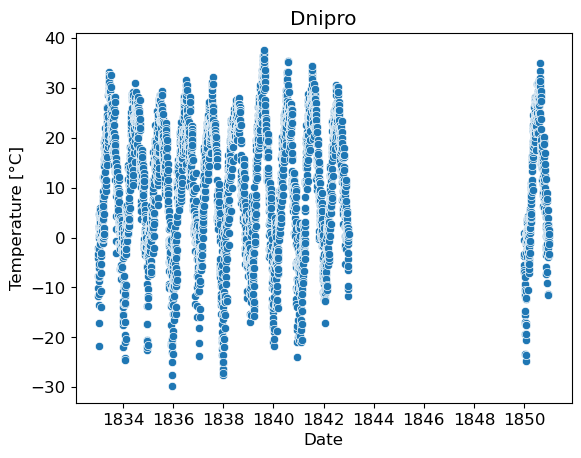

In [7]:
df = pd.read_csv(f'{file_readdir}/Dnipro.tsv', sep='\t',skiprows=12)
make_date_col(df)
df = select_dates(df)
df['P'] = pd.to_numeric(df['P'])
df['T'] = pd.to_numeric(df['T'])
df = df.replace(-999.9,np.NaN)             # replace -999.9 by NaN
df = df.dropna(subset=['T', 'P'], how='all') # drop if both NaN

# check days when less than 3 obs are available
valid_days = df.groupby('Date')['Time'].nunique()
unvalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df[df['Date'].isin(unvalid_dates)]

if df_lt3.empty: print('no days with less than 3 obs, yay!')

# weighted average for temperature:
df_ta = df.groupby('Date').apply(
    lambda group: (group['T'] * group['Time'].map(default_weights)).sum()/group['Time'].map(default_weights).sum()
)
df_ta = pd.DataFrame({'TMP2m': df_ta * 1.25}) # conversion to Celsius
df_ta = df_ta.reset_index()
df_ta.to_csv(f'{file_savedir}Ukr-Dnipro_TMP2m.csv')

sns_plot = sns.scatterplot(x=df_ta['Date'].reset_index(drop=True), y=df_ta['TMP2m'])
sns_plot.set_title(r'Dnipro')
sns_plot.set_ylabel('Temperature [°C]')


## Kherson

no days with less than 3 obs, yay!


/tmp/ipykernel_2875197/694487612.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ta = df.groupby('Date').apply(


Text(0, 0.5, 'Temperature [°C]')

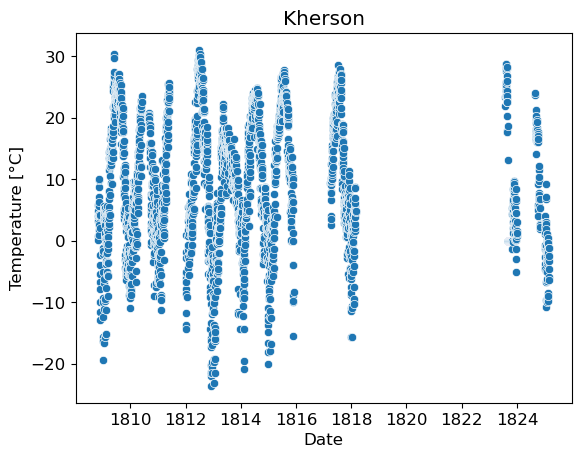

In [8]:
df = pd.read_csv(f'{file_readdir}/Kherson_pre1825.tsv', sep='\t',skiprows=12)
make_date_col(df)
df = select_dates(df)
#df['T'] = pd.to_numeric(df['T'])
df = df.replace(-999.9,np.NaN)          # replace -999.9 by NaN
df = df.dropna(subset=['T_on_N', 'T_on_S', 'P'], how='all') # drop if both NaN
df = df.reset_index()
df['T'] = (df['T_on_N']+df['T_on_S'])/2

# check if there are any days when not all the three obs are available

# check days when less than 3 obs are available
valid_days = df.groupby('Date')['Time'].nunique()
invalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df[df['Date'].isin(invalid_dates)]

if df_lt3.empty: print('no days with less than 3 obs, yay!')
else: print('Check! There are days with less than 3 obs.')

df = df[df['Date'].isin(valid_dates)]

# weighted average for temperature:
df_ta = df.groupby('Date').apply(
    lambda group: (group['T'] * group['Time'].map(default_weights)).sum()/group['Time'].map(default_weights).sum()
)
df_ta = pd.DataFrame({'TMP2m': df_ta * 1.25})
df_ta = df_ta.reset_index()
# df_ta.to_csv(f'{file_savedir}Ukr_Kyiv.csv')

sns_plot = sns.scatterplot(x=df_ta['Date'].reset_index(drop=True), y=df_ta['TMP2m'])
sns_plot.set_title('Kherson')
sns_plot.set_ylabel('Temperature [°C]')

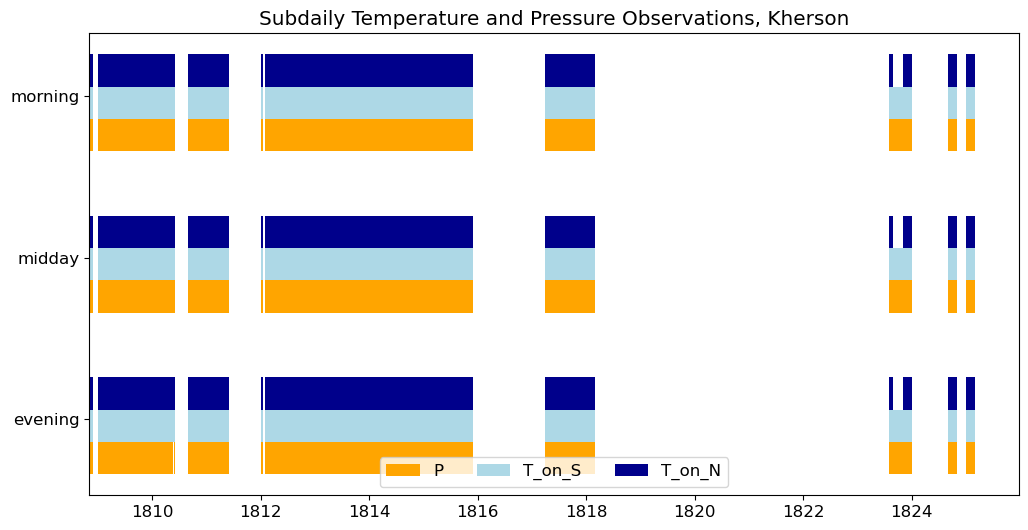

In [16]:
colors = {"T_on_N": "darkblue", "T_on_S": "lightblue", "P": "orange"}

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create positions for each variable within each time category
y_positions = {time: i * 1.5 for i, time in enumerate(time_categories)}
bar_height = 0.9  # Adjusted for better separation

added_labels = set()

# Plot horizontal bars for each variable within each time category
for time_of_day in time_categories:
    for j, var in enumerate(reversed(['T_on_N', 'T_on_S', 'P'])):
        dates = df[df[var].notna() & (df["Time"] == time_of_day)]["Date"]
        
        # legend labels, avoid duplicates
        label = var if var not in added_labels else ""
        added_labels.add(var)
        
        ax.barh(
            y=y_positions[time_of_day] + j * (bar_height/3),  # Offset for each variable
            width=1,
            left=dates,
            height=bar_height/3,
            color=colors[var],
            label=label,
        )

# Format the plot
ax.set_yticks([y_positions[time] + bar_height/2.5 for time in time_categories])
ax.set_yticklabels(time_categories)
ax.set_title("Subdaily Temperature and Pressure Observations, Kherson")
ax.legend(loc='lower center', ncol=3)
plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/image/Kherson_obscounts_tod.png')
plt.show()

it can be misleading, because I'm removing the days where ALL the `T_on_N`, `T_on_S` and `P` are missing. There are days, however, where only one of these 3 vars is missing, or 2 of them. if one of the `T` vars is  missing, doing the average with `df['T'] = (df['T_on_N']+df['T_on_S'])/2` is wrong. I now want to explore some way that can tell me the days in which one of these obs is missing.

In [18]:
# Identify days where at least one of the three variables is missing

# Create a boolean mask for missing observations
missing_obs = df[['T_on_N', 'T_on_S', 'P']].isna()

# Count the number of missing values per day
missing_obs_per_day = df.groupby('Date')[['T_on_N', 'T_on_S', 'P']].apply(lambda x: x.isna().sum())

# Filter to show only dates where at least one variable is missing (but not all)
incomplete_days = missing_obs_per_day[(missing_obs_per_day > 0).any(axis=1)]
incomplete_days.to_csv(f'{file_readdir}/Kherson_incomplete_days.csv')
incomplete_days.sum()

T_on_N    188
T_on_S      3
P           1
dtype: int64

## Kyív

Check! There are days with less than 3 obs.


/tmp/ipykernel_2875197/1480715005.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ta = df.groupby('Date').apply(


Text(0, 0.5, 'Temperature [°C]')

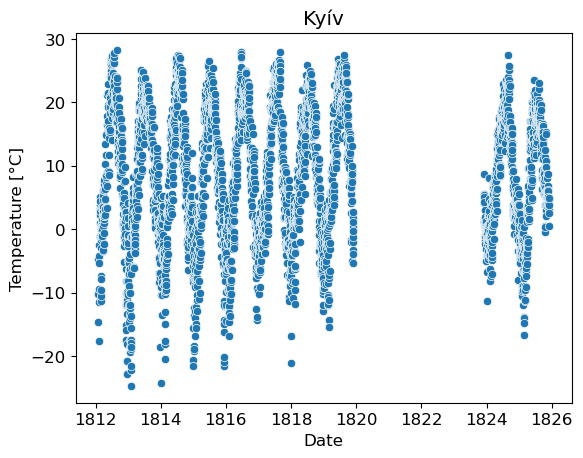

In [5]:
df = pd.read_csv(f'{file_readdir}/Kyiv_ta_pre1837.tsv', sep='\t',skiprows=12)
make_date_col(df)
df = select_dates(df)
df['T'] = pd.to_numeric(df['T'])
df = df.replace(-999.9,np.NaN)          # replace -999.9 by NaN
df = df.dropna(subset=['T'], how='all') # drop if both NaN

# check days when less than 3 obs are available
valid_days = df.groupby('Date')['Time'].nunique()
invalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df[df['Date'].isin(invalid_dates)]

if df_lt3.empty: print('no days with less than 3 obs, yay!')
else: print('Check! There are days with less than 3 obs.')

df = df[df['Date'].isin(valid_dates)]

# weighted average for temperature:
df_ta = df.groupby('Date').apply(
    lambda group: (group['T'] * group['Time'].map(default_weights)).sum()/group['Time'].map(default_weights).sum()
)
df_ta = pd.DataFrame({'TMP2m': df_ta * 1.25})
df_ta = df_ta.reset_index()
df_ta.to_csv(f'{file_savedir}Ukr_Kyiv.csv')

sns_plot = sns.scatterplot(x=df_ta['Date'].reset_index(drop=True), y=df_ta['TMP2m'])
sns_plot.set_title(r'Kyív')
sns_plot.set_ylabel('Temperature [°C]')


look at times of day when observations are missing

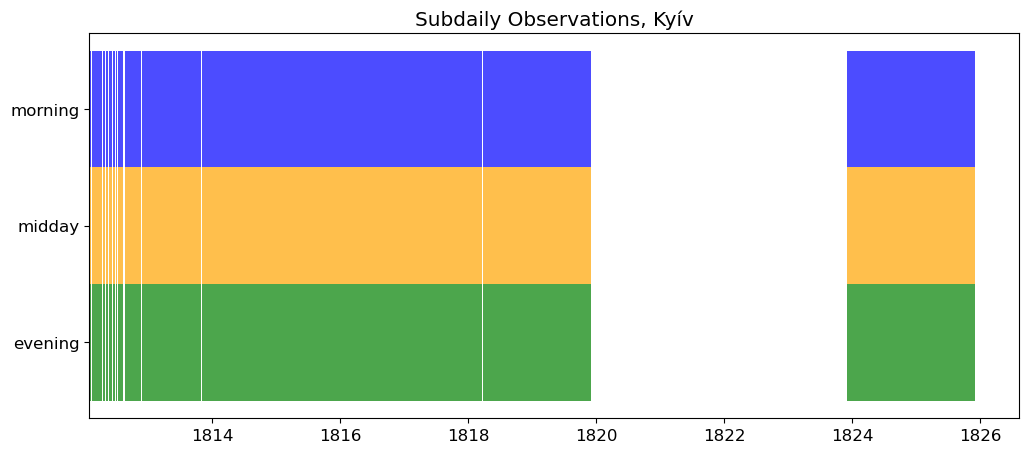

In [6]:
df_short = df#[df['Date']<'1820-01-01']
missing_counts={}
colors = {"morning": "blue", "midday": "orange", "evening": "green"}

# Create the plot with dates on the x-axis and time categories on the y-axis
fig, ax = plt.subplots(figsize=(12, 5))

# Define y-axis positions for the time categories
y_positions = {time: i for i, time in enumerate(time_categories)}

# Plot horizontal bars for each time of day
for time_of_day in time_categories:
    dates = df_short[df_short["Time"] == time_of_day]["Date"]
    ax.barh(y=y_positions[time_of_day], width=1, left=dates,
            height=1, color=colors[time_of_day], label=time_of_day, alpha=0.7)

    total_dates = df_short['Date'].nunique()
    present_dates = dates.nunique()
    missing_counts[time_of_day] = total_dates - present_dates

ax.set_yticks(range(len(time_categories)))
ax.set_yticklabels(time_categories)
ax.set_title("Subdaily Observations, Kyív")

plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/image/Kyiv_obscounts_tod.png')
plt.show()
